#<font color='#97171e'>AIT - Master in Data Science</font> 📈
# **Module 9**
# Recurrent neural networks (RNN)

RNN are used for speech recognition, voice recognition, time series prediction, and natural language processing.

RNN works on the principle of saving the output of a particular layer and feeding this back to the input in order to predict the output of the layer.

Below is how you can convert a Feed-Forward Neural Network into a Recurrent Neural Network:

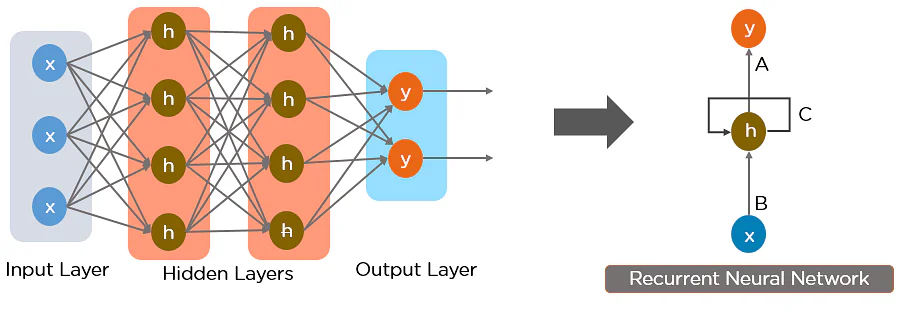

The nodes in different layers of the neural network are compressed to form a single layer of recurrent neural networks. A, B, and C are the parameters of the network.

Here, “x” is the input layer, “h” is the hidden layer, and “y” is the output layer. A, B, and C are the network parameters used to improve the output of the model. At any given time t, the current input is a combination of input at x(t) and x(t-1). The output at any given time is fetched back to the network to improve on the output.

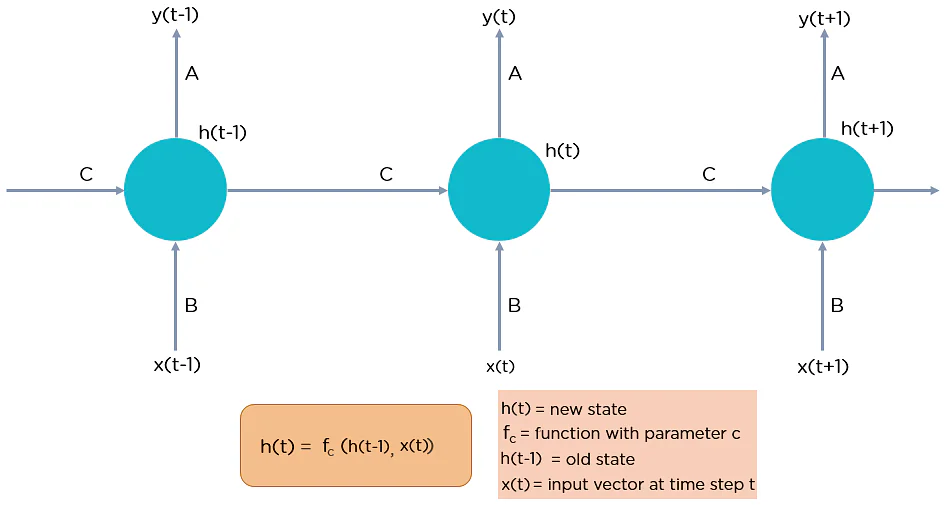

## Why Recurrent Neural Networks?

RNN were created because there were a few issues in the feed-forward neural network:

    Cannot handle sequential data
    Considers only the current input
    Cannot memorize previous inputs

The solution to these issues is the RNN. An RNN can handle sequential data, accepting the current input data, and previously received inputs. RNNs can memorize previous inputs due to their internal memory.

## How Does Recurrent Neural Networks Work?

In Recurrent Neural networks, the information cycles through a loop to the middle hidden layer.

The input layer ‘x’ takes in the input to the neural network and processes it and passes it onto the middle layer.

The middle layer ‘h’ can consist of multiple hidden layers, each with its own activation functions and weights and biases. If you have a neural network where the various parameters of different hidden layers are not affected by the previous layer, ie: the neural network does not have memory, then you can use a recurrent neural network.

The Recurrent Neural Network will standardize the different activation functions and weights and biases so that each hidden layer has the same parameters. Then, instead of creating multiple hidden layers, it will create one and loop over it as many times as required.

<img src="Fully_connected_Recurrent_Neural_Network.gif" alt="Fully Connected Recurrent Neural Network" width="500" >

## Feed-Forward Neural Networks vs Recurrent Neural Networks

A feed-forward neural network allows information to flow only in the forward direction, from the input nodes, through the hidden layers, and to the output nodes. There are no cycles or loops in the network.

Below is how a simplified presentation of a feed-forward neural network looks like:
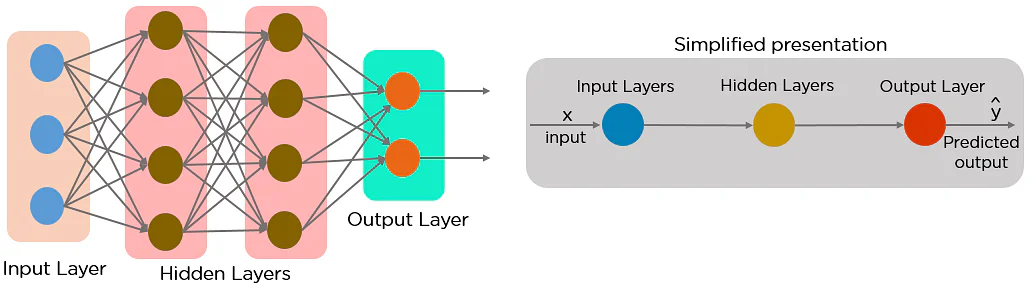

In a feed-forward neural network, the decisions are based on the current input. It doesn’t memorize the past data, and there’s no future scope. Feed-forward neural networks are used in general regression and classification problems.

## Example

We'll do the following example: https://victorzhou.com/blog/keras-rnn-tutorial/

Dataset link: https://ai.stanford.edu/~amaas/data/sentiment/

### Preparing the data

In [ ]:
from tensorflow.keras.preprocessing import text_dataset_from_directory

# Assumes you're in the root level of the dataset directory.
# If you aren't, you'll need to change the relative paths here.
train_data = text_dataset_from_directory("train")
test_data = text_dataset_from_directory("test")

There’s one more small thing to do. If you browse through the dataset, you’ll notice that some of the reviews include `<br />` markers in them, which are HTML line breaks. We want to get rid of those, so we’ll modify our data prep a bit:

In [ ]:
from tensorflow.strings import regex_replace

def prepareData(dir):
  data = text_dataset_from_directory(dir)
  return data.map(
    lambda text, label: (regex_replace(text, '<br />', ' '), label),
  )

train_data = prepareData('./train')
test_data = prepareData('./test')

Now, all `<br />` instances in our dataset have been replaced with spaces. You can try printing some of the dataset if you want:

In [ ]:
for text_batch, label_batch in train_data.take(1):
  print(text_batch.numpy()[0])
  print(label_batch.numpy()[0]) # 0 = negative, 1 = positive

### Building the model

We’ll use the Sequential class, which represents a linear stack of layers. To start, we’ll instantiate an empty sequential model and define its input type:

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input

model = Sequential()
model.add(Input(shape=(1,), dtype="string"))

Our model now takes in 1 string input - time to do something with that string.

#### Text Vectorization

Our first layer will be a TextVectorization layer, which will process the input string and turn it into a sequence of integers, each one representing a token.

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_tokens = 1000
max_len = 100
vectorize_layer = TextVectorization(
  # Max vocab size. Any words outside of the max_tokens most common ones
  # will be treated the same way: as "out of vocabulary" (OOV) tokens.
  max_tokens=max_tokens,
  # Output integer indices, one per string token
  output_mode="int",
  # Always pad or truncate to exactly this many tokens
  output_sequence_length=max_len,
)

To initialize the layer, we need to call .adapt():

In [ ]:
# Call adapt(), which fits the TextVectorization layer to our text dataset.
# This is when the max_tokens most common words (i.e. the vocabulary) are selected.
train_texts = train_data.map(lambda text, label: text)
vectorize_layer.adapt(train_texts)

Finally, we can add the layer to our model:

In [ ]:
model.add(vectorize_layer)

#### Embedding

Our next layer will be an Embedding layer, which will turn the integers produced by the previous layer into fixed-length vectors.

In [ ]:
from tensorflow.keras.layers import Embedding

max_tokens = 1000
# Note that we're using max_tokens + 1 here, since there's an
# out-of-vocabulary (OOV) token that gets added to the vocab.
model.add(Embedding(max_tokens + 1, 128))

#### The Recurrent Layer
Finally, we’re ready for the recurrent layer that makes our network a RNN! We’ll use a Long Short-Term Memory (LSTM) layer, which is a popular choice for this kind of problem. It’s very simple to implement:

In [ ]:
from tensorflow.keras.layers import LSTM

# 64 is the "units" parameter, which is the
# dimensionality of the output space.
model.add(LSTM(64))

To finish off our network, we’ll add a standard fully-connected (Dense) layer and an output layer with sigmoid activation:

In [ ]:
from tensorflow.keras.layers import Dense

model.add(Dense(64, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

The sigmoid activation outputs a number between 0 and 1, which is perfect for our problem - 0 represents a negative review, and 1 represents a positive one.

### Compiling the model
Before we can begin training, we need to configure the training process. We decide a few key factors during the compilation step, including:

* The optimizer. We’ll stick with a pretty good default: the Adam gradient-based optimizer. Keras has many other optimizers you can look into as well.

* The loss function. Since we only have 2 output classes (positive and negative), we’ll use the Binary Cross-Entropy loss. See all Keras losses.

* A list of metrics. Since this is a classification problem, we’ll just have Keras report on the accuracy metric.

Here’s what that compilation looks like:

In [ ]:
model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy'],
)

### Training the Model

In [ ]:
model.fit(train_data, epochs=10)